# Covid-19 Vaccines in California and their Impacts

## Data Analysis

### Hypothesis:
#### 1.	Vaccines have directly impacted California’s case and death rates.
#### 2.	College towns had an impact on Covid-19 surges in 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import gmaps
import datetime as dt

#import API key for gmaps
from config import gkey
gmaps.configure(api_key=gkey)

In [2]:
# import required dataframes:

clean_case = pd.read_csv('Data/clean_case.csv')
vaccine_df = pd.read_csv('Data/vaccine_df.csv')
ca_vaccinations = pd.read_csv('Data/ca_vaccinations.csv')
county_data = pd.read_csv('Data/county_data.csv')
Hosp_Analysis=pd.read_csv('Data/Hosp_Analysis.csv')

#reformat dates:
clean_case['date']=pd.to_datetime(clean_case.date)
clean_case.sort_values(by='date')

ca_vaccinations['administered_date']=pd.to_datetime(ca_vaccinations.administered_date)
ca_vaccinations.sort_values(by='administered_date')

Hosp_Analysis['Date']=pd.to_datetime(Hosp_Analysis.Date)

## Research Analysis

### 1.	How has the introduction of the Covid vaccine affected case/death rate in California?

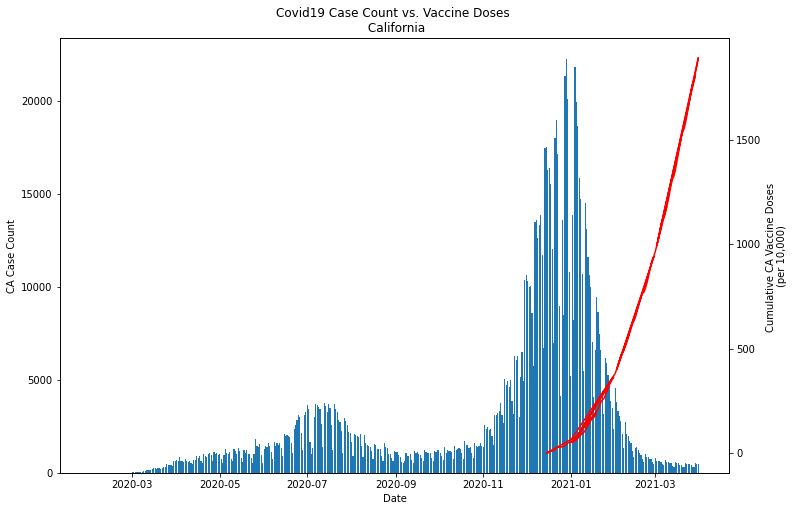

In [3]:
#Covid cases vs. vaccinations

#covid case & dates for bar graph
x1=(clean_case['date'])
y1=(clean_case['cases'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Case Count")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))
plt.title('Covid19 Case Count vs. Vaccine Doses \n California')
plt.savefig('Covid19_CaseCount_vs_Vaccine')
plt.show()

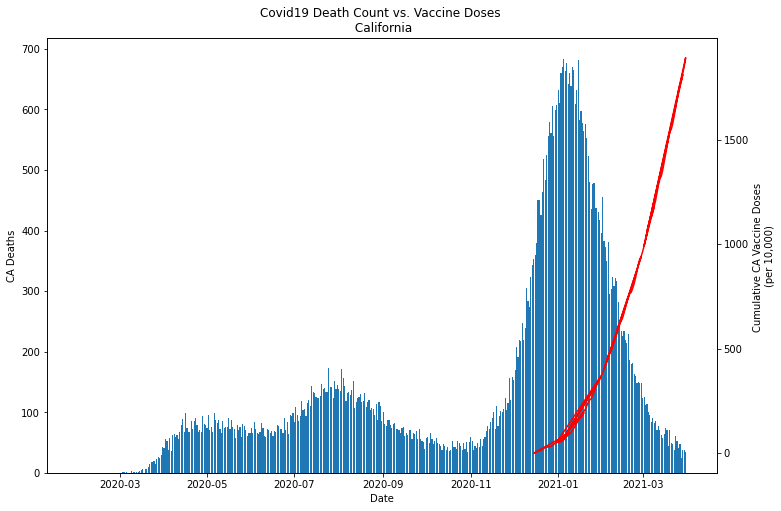

In [4]:
#covid deaths vs. vaccinations 
death_by_date = clean_case.groupby(['date'],as_index=False).agg({'deaths':['sum']})
death_by_date.columns = death_by_date.columns.droplevel(1)

#covid case & dates for bar graph
x1=(death_by_date['date'])
y1=(death_by_date['deaths'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Deaths")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.title('Covid19 Death Count vs. Vaccine Doses \n California')
plt.savefig('Covid19_DeathCount_vs_Vaccine')

plt.show()

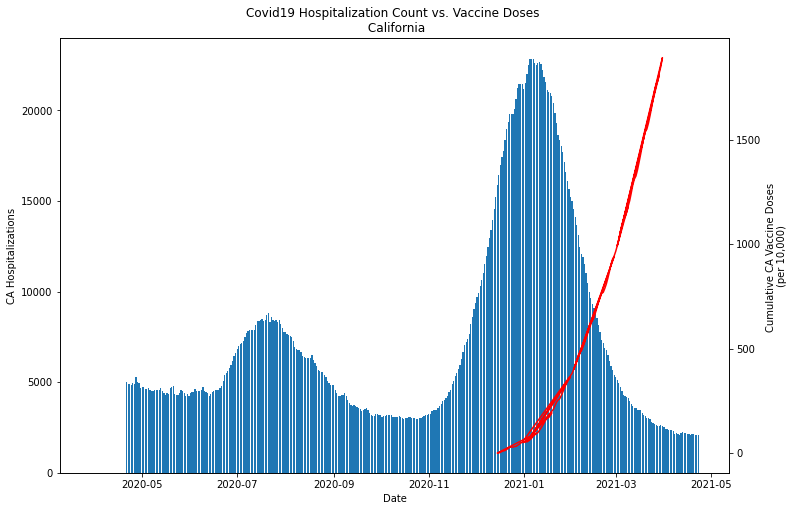

In [6]:
#covid deaths vs. vaccinations 

#covid hospital case & dates for bar graph
x1=(Hosp_Analysis['Date'])
y1=(Hosp_Analysis['Hospitalized Patients'])

#vaccine counts and dates for line graph
x2=ca_vaccinations['administered_date']
y2=ca_vaccinations['cumulative_doses_by_10000']

#format figure
fig, axis1 = plt.subplots(figsize=(12,8))
axis2=axis1.twinx()    #create a second axis sharing the x-axis

#create bar graph using CA case counts
axis1.bar(x1,y1,)
axis1.set_ylabel("CA Hospitalizations")
axis1.set_xlabel('Date')

#plot cumulative vaccine counts on 2nd y-axis
axis2.plot(x2,y2,color='red')
axis2.set_ylabel('Cumulative CA Vaccine Doses \n(per 10,000)')

#change y-ticks for 2nd axis
axis2.set_yticks(np.arange(0,2000,500))

plt.title('Covid19 Hospitalization Count vs. Vaccine Doses \n California')
plt.savefig('Covid19_HospCount_vs_Vaccine')

plt.show()

### 2.	Do “College” towns play a larger role in case surges?

In [41]:
# Dropping counties with less than 100,000 people
county_data1 = county_data.loc[county_data['population']>=100000]

#Grabbing 1st quartile student populations
county_data1.quantile(0.25)

# Locating all counties in the top quartile as "College Counties"
noncollege_counties = county_data1.loc[county_data['% student population']<=4.245]
print(f'There are {len(noncollege_counties)} non-college counties')

#Grabbing 3rd quartile student populations
county_data1.quantile(0.75)

# Locating all counties in the top quartile as "College Counties"
college_counties = county_data.loc[county_data['% student population']>=8.148]
print(f'There are {len(college_counties)} college counties')


There are 9 non-college counties
There are 11 college counties


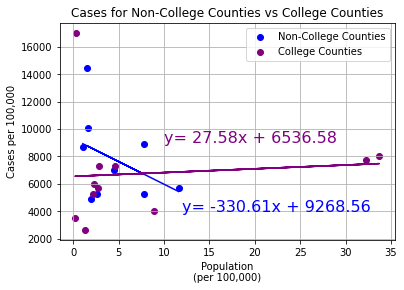

The correlation coefficient for non-college counties is -0.39.
The correlation coefficient for college counties is 0.09.


In [48]:
# Calculate the correlation coefficient and linear regression for cases/population for college and non-college counties

x1_values = noncollege_counties['population']/100000
y1_values = noncollege_counties['cases per 100,000']
x2_values = college_counties['population']/100000
y2_values = college_counties['cases per 100,000']

(slope1, intercept1, rvalue1, pvalue1, stderr1) = sts.linregress(x1_values, y1_values)
regress_values1 = x1_values * slope1 + intercept1
line_eq1 = (f'y= {str(round(slope1,2))}x + {str(round(intercept1,2))}')

(slope2, intercept2, rvalue2, pvalue2, stderr2) = sts.linregress(x2_values, y2_values)
regress_values2 = x2_values * slope2 + intercept2
line_eq2 = (f'y= {str(round(slope2,2))}x + {str(round(intercept2,2))}')

plt.title('Cases for Non-College Counties vs College Counties')
plt.xlabel('Population\n(per 100,000)')
plt.ylabel('Cases per 100,000')
plt.scatter(x1_values, y1_values, c='blue', label='Non-College Counties')
plt.scatter(x2_values, y2_values, c='purple', label='College Counties')
plt.plot(x1_values,regress_values1, color='blue')
plt.annotate(line_eq1, (12,4000), fontsize=16, color='blue')
plt.plot(x2_values,regress_values2, color='purple')
plt.annotate(line_eq2, (10,9000), fontsize=16, color='purple')
plt.legend(loc='upper right')
plt.grid()
plt.show()
print(f'The correlation coefficient for non-college counties is {round(rvalue1,2)}.')
print(f'The correlation coefficient for college counties is {round(rvalue2,2)}.')

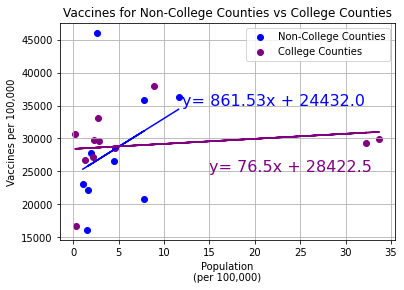

The correlation coefficient for non-college counties is 0.34.
The correlation coefficient for college counties is 0.19.


In [50]:
# Calculate the correlation coefficient and linear regression for vaccines/population for college and non-college counties

x1_values = noncollege_counties['population']/100000
y1_values = noncollege_counties['Fully Vaccinated per 100,000']
x2_values = college_counties['population']/100000
y2_values = college_counties['Fully Vaccinated per 100,000']

(slope1, intercept1, rvalue1, pvalue1, stderr1) = sts.linregress(x1_values, y1_values)
regress_values1 = x1_values * slope1 + intercept1
line_eq1 = (f'y= {str(round(slope1,2))}x + {str(round(intercept1,2))}')

(slope2, intercept2, rvalue2, pvalue2, stderr2) = sts.linregress(x2_values, y2_values)
regress_values2 = x2_values * slope2 + intercept2
line_eq2 = (f'y= {str(round(slope2,2))}x + {str(round(intercept2,2))}')

plt.title('Vaccines for Non-College Counties vs College Counties')
plt.xlabel('Population\n(per 100,000)')
plt.ylabel('Vaccines per 100,000')
plt.scatter(x1_values, y1_values, c='blue', label='Non-College Counties')
plt.scatter(x2_values, y2_values, c='purple', label='College Counties')
plt.plot(x1_values,regress_values1, color='blue')
plt.annotate(line_eq1, (12,35000), fontsize=16, color='blue')
plt.plot(x2_values,regress_values2, color='purple')
plt.annotate(line_eq2, (15,25000), fontsize=16, color='purple')
plt.legend(loc='upper right')
plt.grid()
plt.show()
print(f'The correlation coefficient for non-college counties is {round(rvalue1,2)}.')
print(f'The correlation coefficient for college counties is {round(rvalue2,2)}.')

The above correlations are much stronger for non-college counties than they are for college counties.

Non-college counties also appear to be performing better than college counties:  
  * Cases/100,000 actually decreases for non-college counties as the population increases.  
  * Populations of non-college counties appear to be getting the vaccine at an increased rate based on the drastically higher slope value of the linear regression.

Additional research should look into the population makeup of these counties to find greater correlations.

In [44]:
# Creating heat map of Covid-19 cases

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = county_data['cases per 100,000']

fig1 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_cases = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_cases.max_intensity = 9283
heatmap_layer_cases.point_radius = 0.25

fig1.add_layer(heatmap_layer_cases)

#add college counties to the 2020 heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{cases per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig1.add_layer(markers)

# Display figure

fig1

Figure(layout=FigureLayout(height='420px'))

The above heatmap was originally broken down by year to see the affect of lower student populations due to virtual learning. However, the maps were identical. This also suggests that each county is maintaining it's own Covid-19 curve. No county appears to have dramatically changed its numbers between 2020 and 2021.

In [45]:
# Creating heat map of Vaccines

center = 36.7783,-119.4179
counties = county_data[['latitude', 'longitude']]
cases = county_data['Fully Vaccinated per 100,000']

fig3 = gmaps.figure(center=center, zoom_level=5.5)

heatmap_layer_vaccines = gmaps.heatmap_layer(counties, weights=cases, dissipating=False)
heatmap_layer_vaccines.max_intensity = 30233
heatmap_layer_vaccines.point_radius = 0.25
heatmap_layer_vaccines.gradient = [(255,0,0, 0),
                                   (255,0,0, 1),
                                   (255,255,0, 1),
                                   (0,255,0, 1)]

fig3.add_layer(heatmap_layer_vaccines)

#add college counties to the Vaccine heatmap

info_box_template = """
<dl>
<dt>County</dt><dd>{county}</dd>
<dt>% Students</dt><dd>{% student population}</dd>
<dt>Cases per 100,000</dt><dd>{Fully Vaccinated per 100,000}</dd>
</dl>
"""
# Store the DataFrame Row

county_info = [info_box_template.format(**row) for index, row in college_counties.iterrows()]
locations = college_counties[['latitude', 'longitude']]

# Add marker layer ontop of heat map

markers = gmaps.marker_layer(locations, info_box_content=county_info)
fig3.add_layer(markers)

# Display figure

fig3

Figure(layout=FigureLayout(height='420px'))

Inverted colors on Vaccines heat map as a greater number of vaccines per 100,000 people is considered good.

### 3.	Are there “Vaccination Deserts”? What impact have Covid-19 and the vaccines had in these areas?